# Benchmarking Ripley's K implementations

**Date** : 2020-08-04

Small comparison of three different implementations of the Ripley's K - mainly to assess whether optimization introduces relevant gains in performance.

In [4]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
from typing import Callable, List, Tuple, Union, Iterator
import pandas as pd

## Generate Test Data

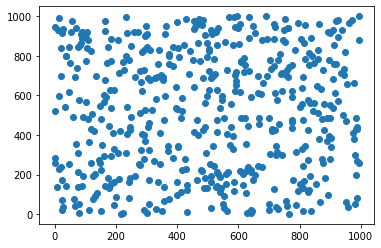

In [6]:
'Define some random pts in space'
L = 1000
area = L**2
n_pts = 500
xs, ys = np.random.randint(low=0,
                           high=L,
                           size=(2, n_pts))
plt.scatter(xs, ys);

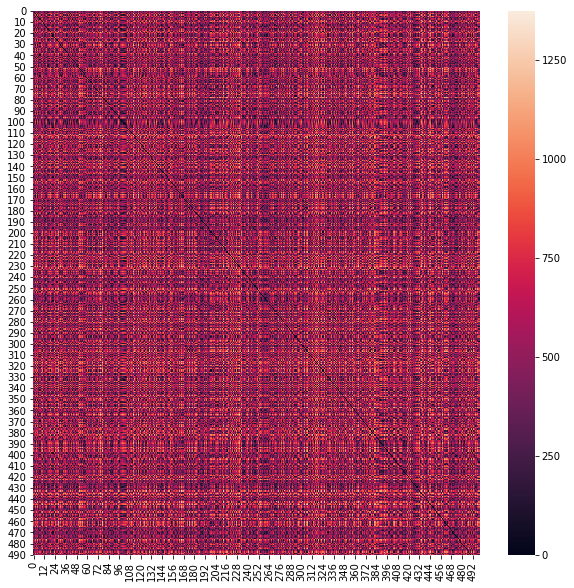

In [7]:
from scipy.spatial.distance import cdist
crd = np.hstack((xs[:,np.newaxis],
                 ys[:,np.newaxis]))

D = cdist(crd,crd)
fig,ax = plt.subplots(1,1,figsize = (10,10))
ax = sns.heatmap(D)

plt.show()

## Define implementation variants

- K_t_1 : original implementation
- K_t_2 : adjusted for-loop
- K_t_3 : cython implementation with adjusted for-loop

In [8]:
def K_t_1(t : float,
          D : np.ndarray,
          area : float,
          n_pts : int)->float:
    """
    Univariate Ripley function. From:
    https://en.wikipedia.org/wiki/Spatial_descriptive_statistics
    
    """
    s = 0
    for i in range(n_pts):
        for j in range(n_pts):
            if i != j:
                s += int(D[i, j] < t)
    s *= area
    s /= (n_pts**2)
    return s

In [9]:
def K_t_2(t : float,
          D : np.ndarray,
          area : float,
          n_pts : int)->float:
    s  = 0
    for i in range(n_pts-1):
        for j in range(i+1,n_pts):
            s += int(D[i,j] < t)
    s *= area
    s /= (n_pts**2)
    return s*2

In [10]:
%%cython
from numpy cimport ndarray as ar
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
def K_t_3(double t,
         ar[double,ndim =2] D,
         double area,
         int n_pts):
    
    cdef double s  = 0.0
    cdef int i,j
    
    for i in range(n_pts-1):
        for j in range(i+1,n_pts):
            s += int(D[i,j] < t)
            
    s = s * area
    s = s / float(n_pts)**2
    
    return s*2.0

### Evaluate performance

`eval_Ks` will take a function (`K_t_x`) and compute $K(r)$ for a given array or iterator of distances, returning the output and the required time to perform the computations.

In [11]:
# define evaluation function
def eval_Ks(fun : Callable,
            times : Union[np.ndarray,Iterator],
            *args,
            **kwargs)->Tuple[List[float],float]:
    
    t_0 = time.time()
    out = list()
    for t in times:
        out.append(fun(t,*args,**kwargs))
    t_end = time.time()
    t_tot = t_end - t_0
    return (out,t_tot)

In [12]:
# distances to iterate over
dists = range(0,L,50)
# dicts to hold results
vals = {}
times = {}

In [13]:
# evaluate implementations
for k in range(1,4):
    vals[f"K_{k}"],times[f"K_{k}"] = eval_Ks(eval(f"K_t_{k}"),
                                             dists,
                                             D,
                                             area,
                                             n_pts)

Make sure that all implementations provides the same results

In [14]:
vals = pd.DataFrame(vals)
vals

,K_1,K_2,K_3
0,0.0,0.0,0.0
1,7432.0,7432.0,7432.0
2,28200.0,28200.0,28200.0
3,61000.0,61000.0,61000.0
4,103384.0,103384.0,103384.0
5,153480.0,153480.0,153480.0
6,209832.0,209832.0,209832.0
7,271016.0,271016.0,271016.0
8,334680.0,334680.0,334680.0
9,401728.0,401728.0,401728.0


Plot Run times

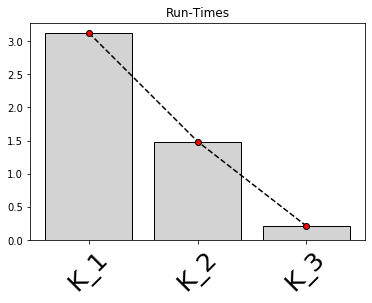

In [15]:
fig,ax = plt.subplots(1,1)
xx = np.arange(3)
yy = list(times.values())
ax.bar(xx,
       yy,
       facecolor = "lightgray",
       edgecolor = "black")

ax.plot(xx,
        yy,
        "--o",
        color = "black",
        markerfacecolor = "red")

ax.set_xticks(np.arange(3))
ax.set_xticklabels(list(times.keys()),
                   fontsize = 25,
                   rotation = 45
                  )
ax.set_title("Run-Times")
plt.show()